# A Data science with Python project by:

---

> **Onur Ümit Şener** - *2006102010*

# &

> **Yağız Ali Yağcıoğlu**- *19006102047*

---



# Imports
We need to import our files and libraries first

**[Click here](https://docs.google.com/spreadsheets/d/1o--gKl-XOqx4V0V7Q720GfdqM0TZ1At9/) to get the Google Drive link or [Click here](https://github.com/hardenedcotton/ColabFiles/blob/main/TR_elektrik.xls?raw=true) to get GitHub link for energy consumption data used. ([TÜİK](https://biruni.tuik.gov.tr/medas/?kn=147&locale=tr))**


**[Click here](https://docs.google.com/spreadsheets/d/1LA3F0pduydTDS7on2wWCWhEUpDUWOCsb/) to get the Google Drive link or [Click here](https://github.com/hardenedcotton/ColabFiles/blob/main/HES%20Konum.xlsx?raw=true) to get GitHub link for the HES location data used. ([Enerji Atlası](https://www.enerjiatlasi.com/hidroelektrik/))**


In [7]:
!pip install geopandas
!pip install plotly.express
!pip install --upgrade plotly

In [37]:
!pip install --upgrade xlrd
!pip install --upgrade openpyxl

     |████████████████████████████████| 242 kB 5.1 MB/s 
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import plotly.express as px
import plotly.graph_objects as go


from geopandas.tools import geocode
from geopy.geocoders import Nominatim
from plotly.subplots import make_subplots

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

Now read the files

# Electricity Data

---



In [3]:
init_data = pd.read_excel('https://github.com/hardenedcotton/ColabFiles/blob/main/TR_elektrik.xls?raw=true')
init_data.head()

,Unnamed: 0,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Adana-1,2337670.0,2401888.0,2678829.0,2765075.0,2898691,3029432,2894674,2951605,3092526,3709263,3887871,3907265,4135636,4112090,3874304,4003428,4794955,5152654,5009294,5677472,5807936,5981130,6671810,6899925,6940010
1,Adıyaman-2,361129.0,395242.0,429554.0,473692.0,506670,518534,524052,545072,573353,593185,703720,777385,832558,844709,835840,900381,918542,961502,1020800,1208069,1102440,1098732,1370471,1139116,1179199
2,Afyonkarahisar-3,479418.0,499922.0,544758.0,611840.0,632332,662356,638077,651683,653469,697510,800434,888464,997479,1061326,1013420,1116419,1182500,1283734,1358985,1436783,1452211,1623043,1787278,1821283,1844721
3,Aksaray-68,113522.0,141300.0,146633.0,178172.0,192506,221476,238357,242839,259374,293610,321174,375594,422910,476976,476668,553243,561652,641665,690515,754358,792287,919210,967155,1069947,1066289
4,Amasya-5,226660.0,250110.0,278647.0,301191.0,307267,320428,325389,326445,307706,331379,339210,376836,421044,439313,447189,466139,493593,519828,537406,570400,603628,606048,649773,638426,650910


## Clearing up the data

---


### Dropping empty data

Let's start with removing the years with non existent data

In [4]:
init_data = init_data.dropna(axis='columns', how='any')
init_data = init_data.rename(columns={"Unnamed: 0":"City"})
init_data.head()

,City,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Adana-1,2898691,3029432,2894674,2951605,3092526,3709263,3887871,3907265,4135636,4112090,3874304,4003428,4794955,5152654,5009294,5677472,5807936,5981130,6671810,6899925,6940010
1,Adıyaman-2,506670,518534,524052,545072,573353,593185,703720,777385,832558,844709,835840,900381,918542,961502,1020800,1208069,1102440,1098732,1370471,1139116,1179199
2,Afyonkarahisar-3,632332,662356,638077,651683,653469,697510,800434,888464,997479,1061326,1013420,1116419,1182500,1283734,1358985,1436783,1452211,1623043,1787278,1821283,1844721
3,Aksaray-68,192506,221476,238357,242839,259374,293610,321174,375594,422910,476976,476668,553243,561652,641665,690515,754358,792287,919210,967155,1069947,1066289
4,Amasya-5,307267,320428,325389,326445,307706,331379,339210,376836,421044,439313,447189,466139,493593,519828,537406,570400,603628,606048,649773,638426,650910


### Splitting the city names


Our city names have their plaka codes in the same column. So let's seperate them.

In [5]:
data = init_data.copy()
data_split = data['City'].str.split('-', expand = True)
print(data_split.head())
print(data_split.shape)

                0   1
0           Adana   1
1        Adıyaman   2
2  Afyonkarahisar   3
3         Aksaray  68
4          Amasya   5
(81, 2)


Now we need to change the city names and insert the plaka codes back. 

In [6]:
#Replace the city names
data['City'] = data_split[0]

#Insert the plaka codes as a new column
data_split[1] = data_split[1].astype(int)
data.insert(0, 'Plaka', data_split[1])

data.head()

,Plaka,City,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,1,Adana,2898691,3029432,2894674,2951605,3092526,3709263,3887871,3907265,4135636,4112090,3874304,4003428,4794955,5152654,5009294,5677472,5807936,5981130,6671810,6899925,6940010
1,2,Adıyaman,506670,518534,524052,545072,573353,593185,703720,777385,832558,844709,835840,900381,918542,961502,1020800,1208069,1102440,1098732,1370471,1139116,1179199
2,3,Afyonkarahisar,632332,662356,638077,651683,653469,697510,800434,888464,997479,1061326,1013420,1116419,1182500,1283734,1358985,1436783,1452211,1623043,1787278,1821283,1844721
3,68,Aksaray,192506,221476,238357,242839,259374,293610,321174,375594,422910,476976,476668,553243,561652,641665,690515,754358,792287,919210,967155,1069947,1066289
4,5,Amasya,307267,320428,325389,326445,307706,331379,339210,376836,421044,439313,447189,466139,493593,519828,537406,570400,603628,606048,649773,638426,650910


### Sorting the cities

 We preffered to sort the cities by their plaka codes

**BE CAUTIOUS!**

We have converted the datatype of the plaka codes to **int** with `.astype(int)` otherwise it would have sorted the numbers by alphebetical order and our end result wouldn't be what we expected.




In [7]:
data = data.sort_values(by='Plaka', kind='quicksort',ignore_index=True)
data = data.set_index('Plaka')

# Graphs


---
We need to visualize our data somehow to get an idea what it contains.


But we also need a clean copy of our data in this state so we won't manipulate our original data or vice versa

In [8]:
cleandata = data.copy()
cleandata = cleandata.drop(axis=1, columns='City')
cleandata

,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Plaka,,,,,,,,,,,,,,,,,,,,,
1,2898691,3029432,2894674,2951605,3092526,3709263,3887871,3907265,4135636,4112090,3874304,4003428,4794955,5152654,5009294,5677472,5807936,5981130,6671810,6899925,6940010
2,506670,518534,524052,545072,573353,593185,703720,777385,832558,844709,835840,900381,918542,961502,1020800,1208069,1102440,1098732,1370471,1139116,1179199
3,632332,662356,638077,651683,653469,697510,800434,888464,997479,1061326,1013420,1116419,1182500,1283734,1358985,1436783,1452211,1623043,1787278,1821283,1844721
4,185791,212358,252014,231187,268529,281807,250213,241275,236338,262439,286950,311838,345438,293873,259592,316464,320447,286843,365252,424047,453451
5,307267,320428,325389,326445,307706,331379,339210,376836,421044,439313,447189,466139,493593,519828,537406,570400,603628,606048,649773,638426,650910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,550072,710174,614627,675203,754978,781240,831315,781594,725377,715618,534733,777345,857684,874774,840977,869438,985402,1044244,1143788,1204021,1218839
78,332044,364603,511466,446339,520663,541743,599119,656858,680315,732298,745085,774472,881337,994753,1063204,929805,975548,1267865,1461845,1640473,1617892
79,46706,58771,57982,67233,74451,77691,78807,84132,92310,106667,118479,128088,141492,164691,187613,222239,247373,218215,266895,275820,304534


## Bar chart
Let's see what does our data look like.

We need to pick a year to examine. Let it be 2019

Text(0, 0.5, 'MW/h x 10^8')

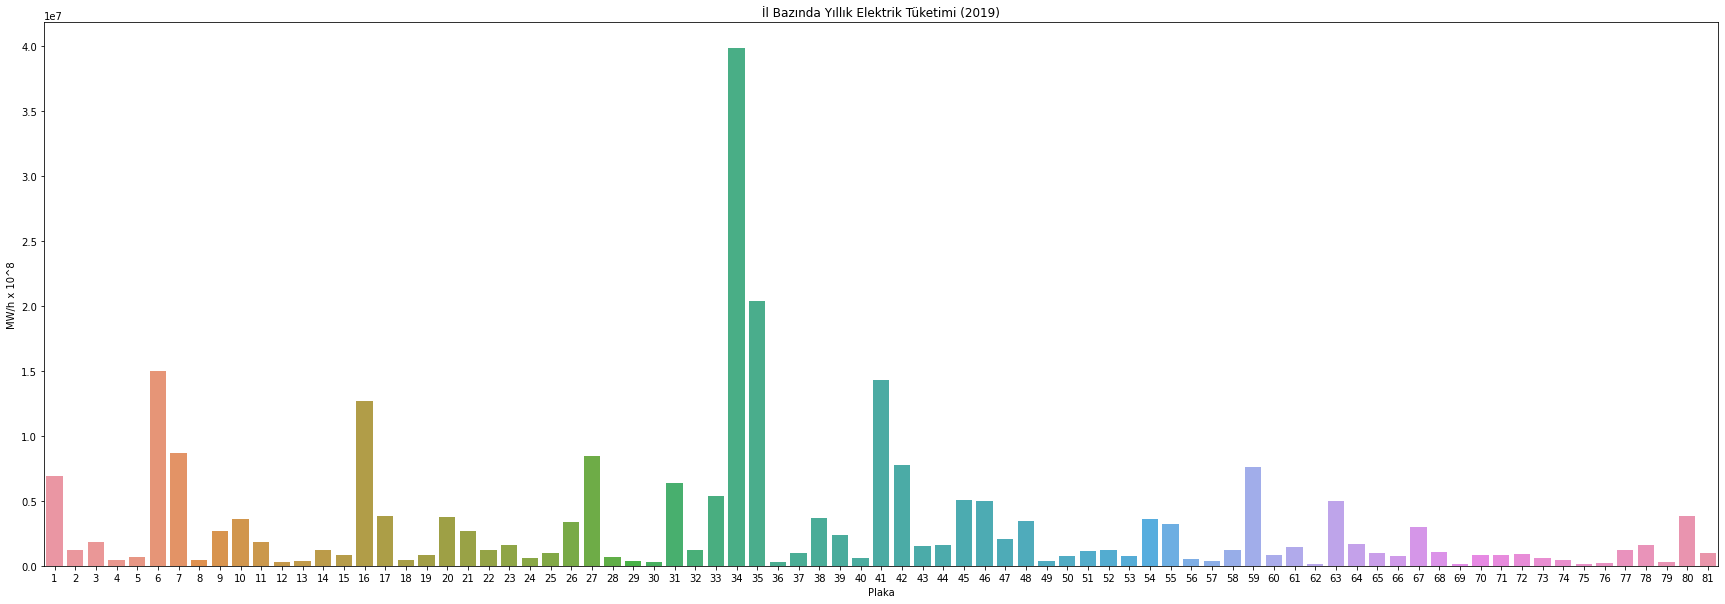

In [ ]:
# Set the width and height of the figure
plt.figure(figsize=(30,10))

# Add title
plt.title("İl Bazında Yıllık Elektrik Tüketimi (2019)")

# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(x=cleandata.index, y=cleandata['2019'])

# Add label for vertical axis
plt.ylabel("MW/h x 10^8")

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(values=cleandata['1999'], labels=data.City.to_numpy()),
              1, 1)
fig.add_trace(go.Pie(values=cleandata['2019'], labels=data.City.to_numpy()),
              1, 2)

fig.update_layout(
    title_text="Türkiye İl Bazında Elektrik Kullanımı 1999-2019",

    annotations=[dict(text='1999', x=0.205, y=0.5, font_size=20, showarrow=False),
                 dict(text='2019', x=0.795, y=0.5, font_size=20, showarrow=False)])

fig.update_traces(textposition='inside', textfont_size=14, hole=.3)
fig.show()

## Line charts
We can see all cities in one year. What about a city in all years?

Here is the data of Izmir:

In [9]:
city_data = cleandata.loc[35]
print(city_data)

1999     8563816
2000     9076114
2001     9024796
2002     9960821
2003    10620177
2004    11369861
2005    11801456
2006    13532583
2007    15478086
2008    15728899
2009    13419636
2010    14902574
2011    16442561
2012    16992650
2013    16914369
2014    17893941
2015    17882459
2016    19241946
2017    19935960
2018    20981892
2019    20363412
Name: 35, dtype: int64


### Single line chart

We isolated Izmir in our data, now it's time to visualize it.

Text(0, 0.5, 'MW/h x 10^8')

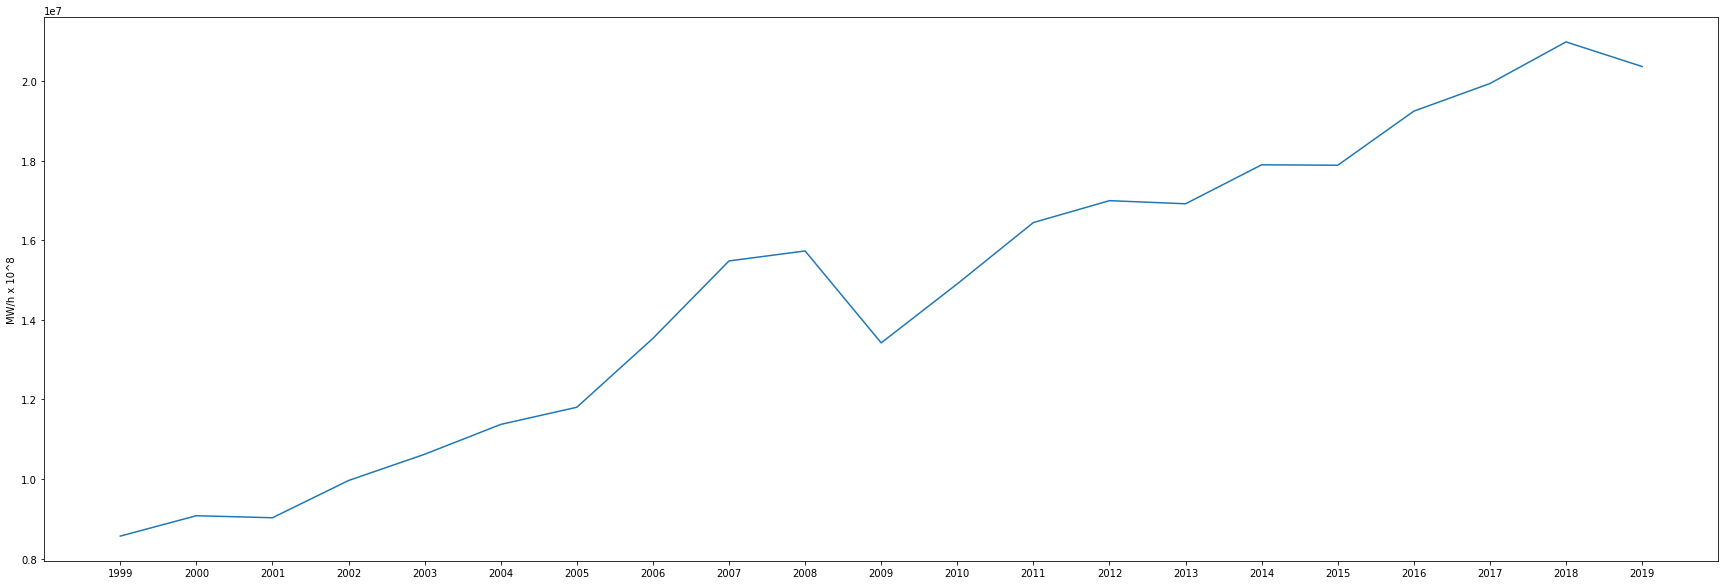

In [9]:
plt.figure(figsize=(30,10))
sns.lineplot(data=city_data)
plt.ylabel("MW/h x 10^8")

### Multi line chart
It looks good. How about adding one more city and comparing them?

In [11]:
city_data2 = cleandata.loc[34]

In [12]:
cities = pd.DataFrame({"35": city_data, "34": city_data2})
cities

,35,34
1999,8563816,17359274
2000,9076114,17703495
2001,9024796,17304305
2002,9960821,18539634
2003,10620177,20432218
2004,11369861,20647640
2005,11801456,23234212
2006,13532583,25751131
2007,15478086,28501616
2008,15728899,30008801


Text(0, 0.5, 'MW/h x 10^8')

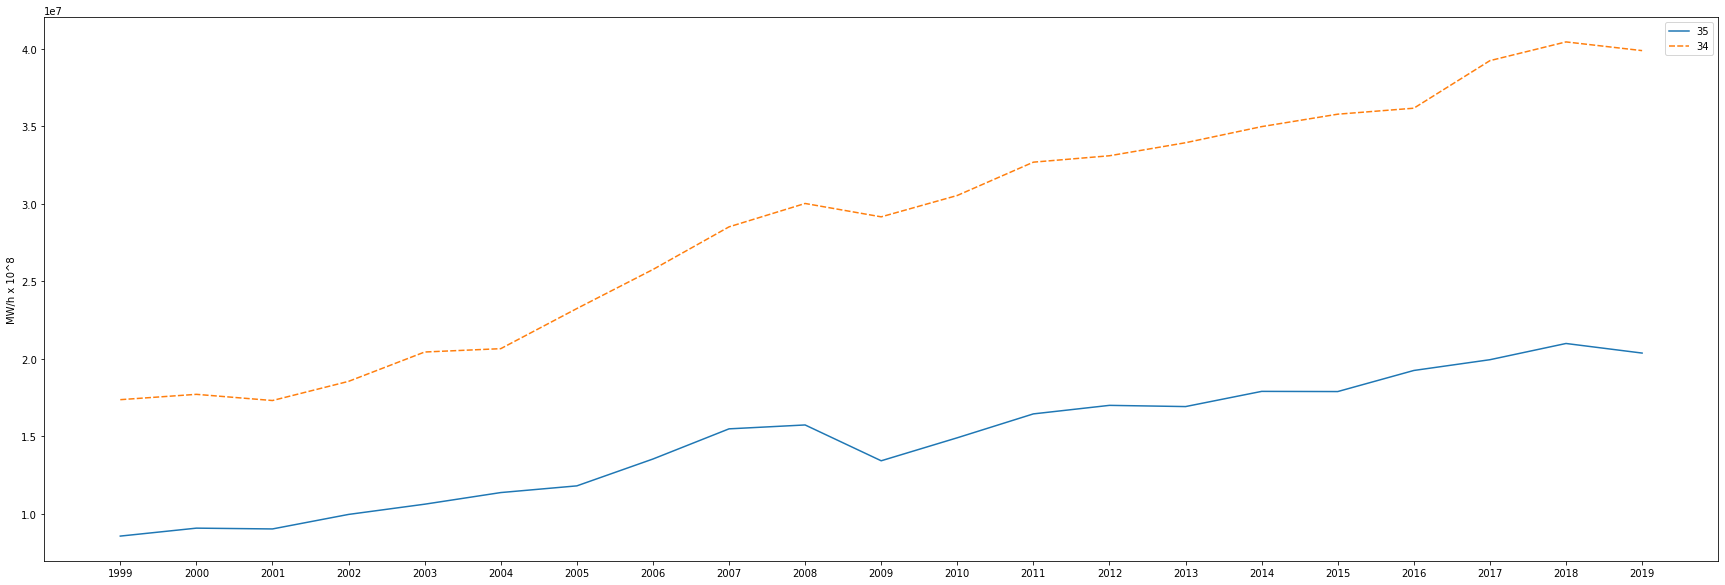

In [12]:
plt.figure(figsize=(30,10))
sns.lineplot(data=cities)
plt.ylabel("MW/h x 10^8")

### Full line chart
Why not see all at once


In [13]:
#cleandata.index = cleandata.index-1
#cleandata.index = cleandata.index+1
print(cleandata.index)

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
            69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81],
           dtype='int64', name='Plaka')


We have to move indicies a step backwards due to a bug caused by using two different dataframes and their first indicies not being zero.

We will reset it after we are done plotting to keep our dataframe's originality.

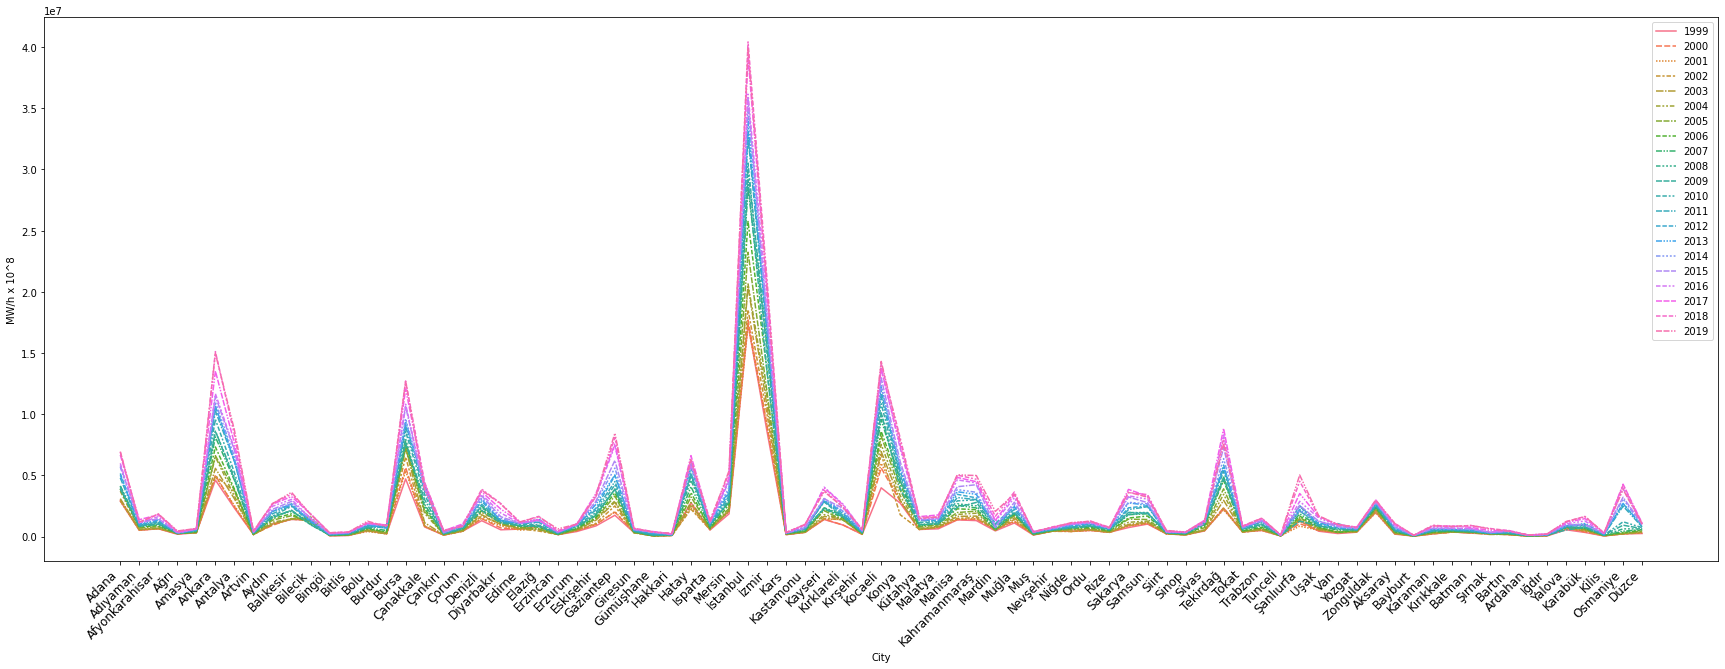

In [14]:
cleandata.index = cleandata.index-1

plt.figure(figsize=(30,10))
sns.lineplot(x=data.City)
sns.lineplot(data=cleandata)
plt.ylabel("MW/h x 10^8")
plt.xticks(rotation=45,horizontalalignment='right',fontsize='large')

cleandata.index = cleandata.index+1

## Scatter diagram

That was too chaotic, maybe this might look better in a scatter diagram.

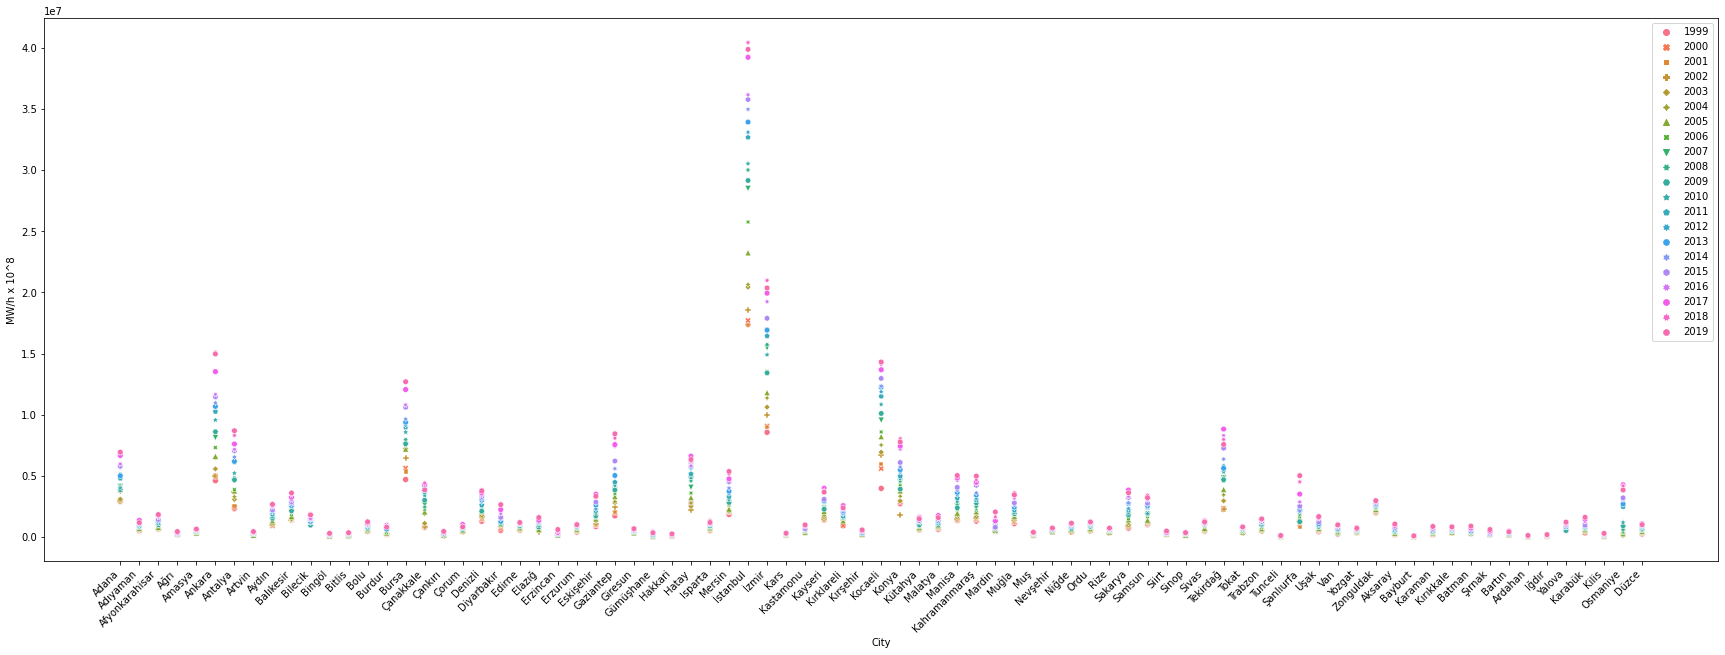

In [15]:
cleandata.index = cleandata.index-1

plt.figure(figsize=(30, 10))
sns.scatterplot(x=data.City)
sns.scatterplot(data=cleandata)
plt.ylabel("MW/h x 10^8")
plt.xticks(rotation=45,horizontalalignment='right')

cleandata.index = cleandata.index+1

# Electricity Maps


---


Let the fun part begin. We are going to depict out data on maps. 

But first, we are going to make some changes in our data. The reason for that is our geolocator sometimes can get confused and pick another locations which we don't expect.

In [14]:
search_data = data['City'].astype(str) + ' Turkey'
data.insert(1,'Search Name',search_data)
data.head()

,City,Search Name,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Plaka,,,,,,,,,,,,,,,,,,,,,,,
1,Adana,Adana Turkey,2898691,3029432,2894674,2951605,3092526,3709263,3887871,3907265,4135636,4112090,3874304,4003428,4794955,5152654,5009294,5677472,5807936,5981130,6671810,6899925,6940010
2,Adıyaman,Adıyaman Turkey,506670,518534,524052,545072,573353,593185,703720,777385,832558,844709,835840,900381,918542,961502,1020800,1208069,1102440,1098732,1370471,1139116,1179199
3,Afyonkarahisar,Afyonkarahisar Turkey,632332,662356,638077,651683,653469,697510,800434,888464,997479,1061326,1013420,1116419,1182500,1283734,1358985,1436783,1452211,1623043,1787278,1821283,1844721
4,Ağrı,Ağrı Turkey,185791,212358,252014,231187,268529,281807,250213,241275,236338,262439,286950,311838,345438,293873,259592,316464,320447,286843,365252,424047,453451
5,Amasya,Amasya Turkey,307267,320428,325389,326445,307706,331379,339210,376836,421044,439313,447189,466139,493593,519828,537406,570400,603628,606048,649773,638426,650910


## Geocoding
Let's start geocoding then.

Geocoding is the most powerful function of the Geopandas library. It takes a string and finds its location on the map.

This process should only take about a minute.

In [15]:
geolocator = Nominatim(user_agent="kaggle_learn")
def my_geocoder(row):
    try:
        point = geolocator.geocode(row).point
        return pd.Series({'Latitude': point.latitude, 'Longitude': point.longitude})
    except:
        return None

data[['Latitude', 'Longitude']] = data.apply(lambda x: my_geocoder(x['Search Name']), axis=1)

print("{}% of addresses were geocoded!".format(
    (1 - sum(np.isnan(data["Latitude"])) / len(data)) * 100))


data = data.loc[~np.isnan(data["Latitude"])]
data = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))
data.crs = {'init': 'epsg:5636'}
data.head()

100.0% of addresses were geocoded!


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,City,Search Name,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Latitude,Longitude,geometry
Plaka,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Adana,Adana Turkey,2898691,3029432,2894674,2951605,3092526,3709263,3887871,3907265,4135636,4112090,3874304,4003428,4794955,5152654,5009294,5677472,5807936,5981130,6671810,6899925,6940010,36.986360,35.325286,POINT (35.325 36.986)
2,Adıyaman,Adıyaman Turkey,506670,518534,524052,545072,573353,593185,703720,777385,832558,844709,835840,900381,918542,961502,1020800,1208069,1102440,1098732,1370471,1139116,1179199,37.789360,38.314110,POINT (38.314 37.789)
3,Afyonkarahisar,Afyonkarahisar Turkey,632332,662356,638077,651683,653469,697510,800434,888464,997479,1061326,1013420,1116419,1182500,1283734,1358985,1436783,1452211,1623043,1787278,1821283,1844721,38.685273,30.642741,POINT (30.643 38.685)
4,Ağrı,Ağrı Turkey,185791,212358,252014,231187,268529,281807,250213,241275,236338,262439,286950,311838,345438,293873,259592,316464,320447,286843,365252,424047,453451,39.529160,43.383564,POINT (43.384 39.529)
5,Amasya,Amasya Turkey,307267,320428,325389,326445,307706,331379,339210,376836,421044,439313,447189,466139,493593,519828,537406,570400,603628,606048,649773,638426,650910,40.650325,35.832915,POINT (35.833 40.650)


It has been successful.

## Markers

Now it's time for a real map. We are going to mark our cities on our maps. We are also going to make our markers show the plaka of the cities on hover and names on click. So we are going to need our plaka codes seperated just for this one.


In [16]:
data_with_plaka = data.copy()
data_with_plaka = data_with_plaka.reset_index()

In [17]:
data_arr = data[['Latitude','Longitude']].to_numpy()

# Create a base map
map = folium.Map(location=[39.382049, 35.507132],
                 zoom_start=7)

for idx, row in data_with_plaka.iterrows():
  Marker([row['Latitude'], row['Longitude']], 
         tooltip = row['Plaka'], 
         popup = row['City']).add_to(map)

# Display the map
map

## Icon Markers
Now it is time to visualize our data on a map. Let's do it with icon markers.

### Percentiles
We are going to calculate then draw our percentile data to choose what to project on our map.

In [18]:
q75, q50, q25 = np.percentile(cleandata['2019'], [75, 50, 25])
d = {'0': [0],
    'min': [cleandata['2019'].min()],
     'q1': [q25],
     'q2': [q50],
     'q3': [(cleandata['2019'].max()-q75)], 
     'max': [cleandata['2019'].max()]}
df = pd.DataFrame(d)
df

,0,min,q1,q2,q3,max
0,0,100554,650910.0,1218839.0,36256181.0,39864324


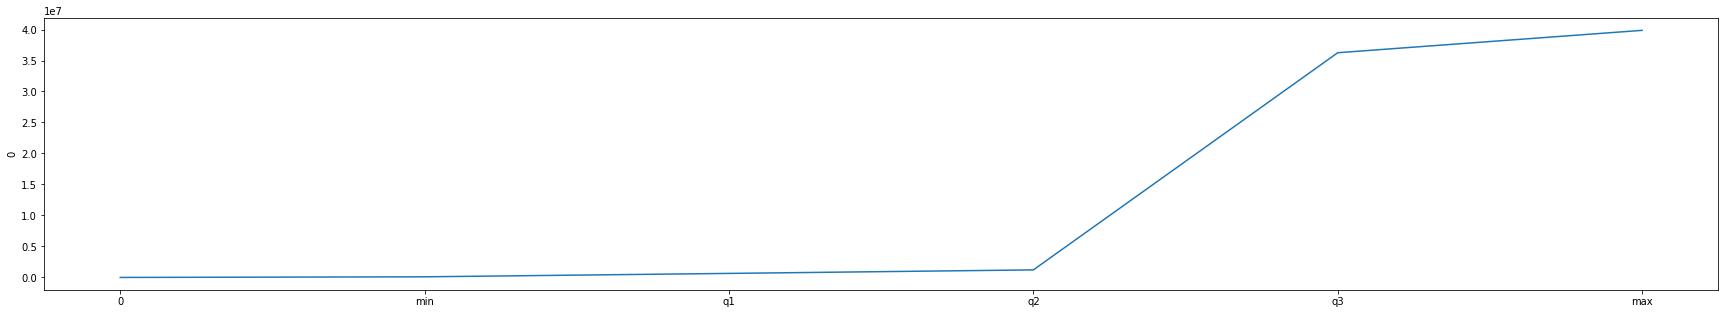

In [19]:
plt.figure(figsize=(30,5))
sns.lineplot(data=df.iloc[0])

### Icon Map

In [20]:
# Create the map
iconmap = folium.Map(location=[39.382049, 35.507132],
                 zoom_start=7)

# Add points to the map
for idx, row in data_with_plaka.iterrows():

        label='{}, {}'.format(row['Plaka'], data['City'].iloc[idx])

        if row['2019'] >= int(df['q3']):
          Marker([row['Latitude'], row['Longitude']], 
                 tooltip=label,
                 popup = str(row['2019']),
                 icon=folium.Icon(color="red",icon='exclamation-sign')).add_to(iconmap)

        elif row['2019'] >= int(df['q2']) and row['2019'] <= int(df['q3']):
          Marker([row['Latitude'], row['Longitude']],
                 tooltip=label,
                 popup = str(row['2019']),
                 icon=folium.Icon(color="orange",icon='thumbs-down')).add_to(iconmap)

        elif row['2019'] >= int(df['q1']) and row['2019'] <= int(df['q2']):
          Marker([row['Latitude'], row['Longitude']], 
                 tooltip=label,
                 popup = str(row['2019']),
                 icon=folium.Icon(color="blue",icon='thumbs-up')).add_to(iconmap)

        elif row['2019'] >= int(df['0']) and row['2019'] <= int(df['q1']):
          Marker([row['Latitude'], row['Longitude']],
                 tooltip=label,
                 popup = str(row['2019']),
                 icon=folium.Icon(color="green",icon='leaf')).add_to(iconmap)

# Display the map
iconmap

## Heatmaps
Let's see our data on a heatmap

### Normalization

We need to normalize our data in order to properly project it on our heatmap.

Here are some normalization techniques:

In [40]:
data.head()

,City,Search Name,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,Latitude,Longitude,geometry
Plaka,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Adana,Adana Turkey,2898691,3029432,2894674,2951605,3092526,3709263,3887871,3907265,4135636,4112090,3874304,4003428,4794955,5152654,5009294,5677472,5807936,5981130,6671810,6899925,6940010,36.986360,35.325286,POINT (35.325 36.986)
2,Adıyaman,Adıyaman Turkey,506670,518534,524052,545072,573353,593185,703720,777385,832558,844709,835840,900381,918542,961502,1020800,1208069,1102440,1098732,1370471,1139116,1179199,37.789360,38.314110,POINT (38.314 37.789)
3,Afyonkarahisar,Afyonkarahisar Turkey,632332,662356,638077,651683,653469,697510,800434,888464,997479,1061326,1013420,1116419,1182500,1283734,1358985,1436783,1452211,1623043,1787278,1821283,1844721,38.685273,30.642741,POINT (30.643 38.685)
4,Ağrı,Ağrı Turkey,185791,212358,252014,231187,268529,281807,250213,241275,236338,262439,286950,311838,345438,293873,259592,316464,320447,286843,365252,424047,453451,39.529160,43.383564,POINT (43.384 39.529)
5,Amasya,Amasya Turkey,307267,320428,325389,326445,307706,331379,339210,376836,421044,439313,447189,466139,493593,519828,537406,570400,603628,606048,649773,638426,650910,40.650325,35.832915,POINT (35.833 40.650)


In [41]:
data_arr1 = data[['Latitude','Longitude']].to_numpy()
heatmap1 = folium.Map(location=[39.382049, 35.507132], 
                      tiles='cartodbpositron', 
                      zoom_start=7)

# Add a heatmap to the base map
HeatMap(data=data_arr1, radius=20).add_to(heatmap1)

# Display the map
heatmap1

In [59]:
year_data1 = data['1999']

print('Original Data\n')
print('Max: ', year_data1.max(),
      '\nMin: ', year_data1.min(),
      '\nMean: ', year_data1.mean(),
      '\nMedian: ',year_data1.median(),
      '\n')
print(year_data1)

Original Data

Max:  17359274 
Min:  32827 
Mean:  1112363.3950617283 
Median:  453506.0 

Plaka
1     2898691
2      506670
3      632332
4      185791
5      307267
       ...   
77     550072
78     332044
79      46706
80     211571
81     244986
Name: 1999, Length: 81, dtype: int64


In [64]:
year_data1 = data['1999'] / data['1999'].count()

print('All Divided by Count\n')
print('Max: ', year_data1.max(),
      '\nMin: ', year_data1.min(),
      '\nMean: ', year_data1.mean(),
      '\nMedian: ',year_data1.median())

All Divided by Count

Max:  214312.02469135803 
Min:  405.2716049382716 
Mean:  13732.881420515156 
Median:  5598.83950617284


Values are too big

In [44]:
year_data1 = data['1999'] / data['1999'].sum()

print('All Divided by summation\n')
print('Max: ', year_data1.max(),
      '\nMin: ', year_data1.min(),
      '\nMean: ', year_data1.mean(),
      '\nMedian: ',year_data1.median())

All Divided by summation

Max:  0.19266367955182956 
Min:  0.00036433381998854955 
Mean:  0.012345679012345675 
Median:  0.00503328276625117


Too small

In [45]:
temp_year =  data['1999']-data['1999'].min()
year_data1 = temp_year / temp_year.max()

print('Subtracted the Minimum Value and Divided by Maximum Value\n')
print('Max: ', year_data1.max(),
      '\nMin: ', year_data1.min(),
      '\nMean: ', year_data1.mean(),
      '\nMedian: ',year_data1.median())

Subtracted the Minimum Value and Divided by Maximum Value

Max:  1.0 
Min:  0.0 
Mean:  0.06230569920432785 
Median:  0.02427958830797797


This should have worked but it won't on our heatmap

---



All the techniques above are useful in different situations.

In our case we are going to normalize our data by dividing it with a constant value.

### 1999 Map

In [69]:
year_data1 = data['1999']/10**4

print('Divided by 10000\n')
print('Max: ', year_data1.max(),
      '\nMin: ', year_data1.min(),
      '\nMean: ', year_data1.mean(),
      '\nMedian: ',year_data1.median(),
      '\n')
print(year_data1)

Divided by 10000

Max:  1735.9274 
Min:  3.2827 
Mean:  111.23633950617284 
Median:  45.3506 

Plaka
1     289.8691
2      50.6670
3      63.2332
4      18.5791
5      30.7267
        ...   
77     55.0072
78     33.2044
79      4.6706
80     21.1571
81     24.4986
Name: 1999, Length: 81, dtype: float64


In [70]:
data_arr1 = data[['Latitude','Longitude']]
data_arr1['Year'] = year_data1
data_arr1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Latitude,Longitude,Year
Plaka,,,
1,36.986360,35.325286,289.8691
2,37.789360,38.314110,50.6670
3,38.685273,30.642741,63.2332
4,39.529160,43.383564,18.5791
5,40.650325,35.832915,30.7267
...,...,...,...
77,40.592707,29.077136,55.0072
78,41.195540,32.623115,33.2044
79,36.779723,37.141689,4.6706


In [72]:
data_arr1 = data_arr1.to_numpy()
data_arr1

array([[  36.9863599 ,   35.3252861 ,  289.8691    ],
       [  37.78936   ,   38.3141101 ,   50.667     ],
       [  38.6852729 ,   30.6427411 ,   63.2332    ],
       [  39.52916   ,   43.3835645 ,   18.5791    ],
       [  40.6503248 ,   35.8329148 ,   30.7267    ],
       [  39.9207886 ,   32.8540482 ,  461.102     ],
       [  36.9009641 ,   30.6954846 ,  232.0467    ],
       [  41.160506  ,   41.8398627 ,   17.3371    ],
       [  37.8483767 ,   27.8435878 ,  102.0355    ],
       [  39.5400798 ,   28.0228793 ,  139.154     ],
       [  40.1435101 ,   29.9752911 ,  132.5846    ],
       [  39.073803  ,   40.7296181 ,    6.2852    ],
       [  38.4950867 ,   42.1678372 ,    8.168     ],
       [  40.6212099 ,   31.6460259 ,   46.9224    ],
       [  37.5183407 ,   30.1691254 ,   22.2085    ],
       [  40.1827657 ,   29.0677305 ,  470.6419    ],
       [  40.0549886 ,   26.9278292 ,   78.0233    ],
       [  40.6667691 ,   33.4526069 ,   11.3351    ],
       [  40.5698389 ,   34.

In [74]:
# Create a base map
heatmap1 = folium.Map(location=[39.382049, 35.507132], 
                      tiles='cartodbpositron', 
                      zoom_start=7)

# Add a heatmap to the base map
HeatMap(data=data_arr1, radius=100).add_to(heatmap1)

# Display the map
heatmap1

### 2019 Map

In [75]:
year_data2 = data['2019']/10**4
print(year_data2)

Plaka
1     694.0010
2     117.9199
3     184.4721
4      45.3451
5      65.0910
        ...   
77    121.8839
78    161.7892
79     30.4534
80    384.2286
81    101.2775
Name: 2019, Length: 81, dtype: float64


In [76]:
data_arr2 = data[['Latitude','Longitude']]
data_arr2['Year'] = year_data2
data_arr2 = data_arr2.to_numpy()

# Create a base map
heatmap2 = folium.Map(location=[39.382049, 35.507132],
                      tiles='cartodbpositron',
                      zoom_start=7)

# Add a heatmap to the base map
HeatMap(data=data_arr2, radius=100).add_to(heatmap2)

# Display the map
heatmap2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# HES Data

---
We are going to inspect the data of hydroelectric dams in Turkey.

Let's import them.


In [52]:
init_hes_data = pd.read_excel('https://github.com/hardenedcotton/ColabFiles/blob/main/HES%20Konum.xlsx?raw=true')
init_hes_data.head()

,Baraj,Şehir,Şirket,Enerji Üretimi
0,Atatürk Barajı ve HES,Şanlıurfa,EÜAŞ,2.405 MW
1,Karakaya Barajı ve HES,Diyarbakır,EÜAŞ,1.800 MW
2,Keban Barajı ve HES,Elazığ,EÜAŞ,1.330 MW
3,Ilısu Barajı ve HES,Mardin,EÜAŞ,1.209 MW
4,Altınkaya Barajı ve HES,Samsun,EÜAŞ,703 MW


## Cleaning and Modifying the Data
We again need to clean and set up our data for geolocating. 

In [53]:
#Replace the city names
hes_data = init_hes_data.copy()
hes_data_split = hes_data['Baraj'].str.split(' ', expand = True)

hes_data['Baraj'] = hes_data_split[0]
hes_search_data = hes_data['Baraj'].astype(str) + ' ' + hes_data['Şehir'].astype(str) + ' Turkey'
hes_data.insert(1,'Search Name', hes_search_data)
hes_data.head()

,Baraj,Search Name,Şehir,Şirket,Enerji Üretimi
0,Atatürk,Atatürk Şanlıurfa Turkey,Şanlıurfa,EÜAŞ,2.405 MW
1,Karakaya,Karakaya Diyarbakır Turkey,Diyarbakır,EÜAŞ,1.800 MW
2,Keban,Keban Elazığ Turkey,Elazığ,EÜAŞ,1.330 MW
3,Ilısu,Ilısu Mardin Turkey,Mardin,EÜAŞ,1.209 MW
4,Altınkaya,Altınkaya Samsun Turkey,Samsun,EÜAŞ,703 MW


## Geocoding


In [54]:
hes_data.shape

(685, 5)

Please note that we have **685** places to geolocate so this process is about to take **5-6 minutes**.

In [55]:
geolocator = Nominatim(user_agent="kaggle_learn")
def my_geocoder(row):
    try:
        point = geolocator.geocode(row).point
        return pd.Series({'Latitude': point.latitude, 'Longitude': point.longitude})
    except:
        return None

hes_data[['Latitude', 'Longitude']] = hes_data.apply(lambda x: my_geocoder(x['Search Name']), axis=1)

print("{}% of addresses were geocoded!".format(
    (1 - sum(np.isnan(hes_data["Latitude"])) / len(hes_data)) * 100))


hes_data = hes_data.loc[~np.isnan(hes_data["Latitude"])]
hes_data = gpd.GeoDataFrame(
    hes_data, geometry=gpd.points_from_xy(hes_data.Longitude, hes_data.Latitude))
hes_data.crs = {'init': 'epsg:5636'}
hes_data.head()

74.01459854014598% of addresses were geocoded!


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Baraj,Search Name,Şehir,Şirket,Enerji Üretimi,Latitude,Longitude,geometry
0,Atatürk,Atatürk Şanlıurfa Turkey,Şanlıurfa,EÜAŞ,2.405 MW,37.480519,38.319849,POINT (38.320 37.481)
1,Karakaya,Karakaya Diyarbakır Turkey,Diyarbakır,EÜAŞ,1.800 MW,38.208590,39.150878,POINT (39.151 38.209)
2,Keban,Keban Elazığ Turkey,Elazığ,EÜAŞ,1.330 MW,38.793986,38.739715,POINT (38.740 38.794)
3,Ilısu,Ilısu Mardin Turkey,Mardin,EÜAŞ,1.209 MW,37.531458,41.846114,POINT (41.846 37.531)
4,Altınkaya,Altınkaya Samsun Turkey,Samsun,EÜAŞ,703 MW,41.330986,35.370846,POINT (35.371 41.331)


We only got **74%** of our data geolocated but this won't be a problem 

since we have more than enough data to give us some ideas about HES placements in Turkey.

# HES Maps

---




## Marker Cluster Map
Now we are going to use Marker Cluster to project dam locations over Turkey.


### Terrain Map
Also let's use a terrain map to see if the placements are related to terrain.

In [56]:
# Create the map
hes_map = folium.Map(location=[39.382049, 35.507132],
                     tiles='stamenterrain',
                     zoom_start=7)

# Add points to the map
mc = MarkerCluster()
for idx, row in hes_data.iterrows():
    if not math.isnan(row['Longitude']) and not math.isnan(row['Latitude']):
        mc.add_child(Marker([row['Latitude'],
                             row['Longitude']],
                             tooltip = row['Baraj'] + ' Barajı'))
hes_map.add_child(mc)

# Display the map
hes_map

Appearently they are not fully but sort of related. Let's try another map style.

### River Map
What about rivers? They must be related right?

In [57]:
# Create the map
hes_map_river = folium.Map(location=[39.382049, 35.507132],
                           tiles='stamentoner',
                           zoom_start=7)

# Add points to the map
mc = MarkerCluster()
for idx, row in hes_data.iterrows():
    if not math.isnan(row['Longitude']) and not math.isnan(row['Latitude']):
        mc.add_child(Marker([row['Latitude'],
                             row['Longitude']], 
                             tooltip = row['Baraj'] + ' Barajı'))
hes_map_river.add_child(mc)

# Display the map
hes_map_river

As we can see, dams are located on top or really close to the rivers.

# Merged Map
Finally, how about seeing both our electricity consumption and dam data in a single map?


In [58]:
# Create a base map
mixmap = folium.Map(location=[39.382049, 35.507132], tiles='stamentoner', zoom_start=7)

# Add a heatmap to the base map
HeatMap(data=data_arr2, radius=100).add_to(mixmap)

mc = MarkerCluster()
for idx, row in hes_data.iterrows():
    if not math.isnan(row['Longitude']) and not math.isnan(row['Latitude']):
        mc.add_child(Marker([row['Latitude'], row['Longitude']], tooltip = row['Baraj'] + ' Barajı'))
mixmap.add_child(mc)


# Display the map
mixmap

As we can see dam placements are naturally not related to electric consumption.